## Anamoly detection on Images of Wood Surfaces

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils,datasets
import os,glob,cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Mounting the data from Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The data I have uploaded here is not the data with 7 images, but it is the augmented data. 

I have used a software called 'roboflow' where we can upload the original data and perform the steps that are needed to augment the data. I have generated 21 images from the free version of it and taken it as the training data

In [3]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/extend-ai-ml-assessment'
!ls {PATH_OF_DATA}

README.dataset.txt  README.roboflow.txt  train


### Data Augmentation

The below is the sample image after augmentation

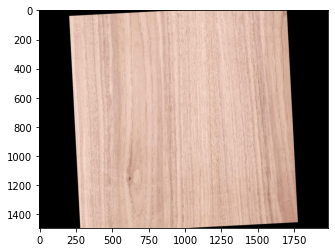

In [4]:
sample = datasets.ImageFolder(root= "/content/gdrive/My Drive/extend-ai-ml-assessment")
width,height = sample[0][0].size
plt.imshow(sample[0][0]);

In [44]:
# Transforms images to a PyTorch Tensor
transform = [transforms.Compose([
                transforms.RandomCrop(size=(1024, 1024)),
                
                transforms.ToTensor()])
]

In [45]:
list_datasets=[]
for t in transform:
  dataset = datasets.ImageFolder('/content/gdrive/My Drive/extend-ai-ml-assessment', transform=t)
  list_datasets.append(dataset)
augmented_dataset = torch.utils.data.ConcatDataset(list_datasets)
# DataLoader is used to load the dataset 
# for training
dataloaders = torch.utils.data.DataLoader(augmented_dataset)
print(f"Number of images in the augmented dataset is {len(dataloaders)}")

Number of images in the augmented dataset is 21


### Implementation of ML Model

To approach this problem, I have used a simple Autoencoder with convolution operations. Here, the image is encoded and generates an output of 256 channels and then in the decoding step, using de-convolutional layers, this image is again reconstructed as the original image. I have taken inspiration from Jimit Bavishi work, as I have observed better results from a simple model rather than implementing a complicated model.

In [46]:
# Creating a PyTorch class
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2,padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
            
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=3, stride=2,padding=2, output_padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU()
        )
    def forward(self, input_image):
      encoded_image = self.encoder(input_image)
      decoded_image = self.decoder(encoded_image)
      return decoded_image

In [47]:
def train(model, x, y, optimizer, loss_function):
  model.zero_grad()# The gradients are set to zero, # the gradient is computed and stored.
  output = model(x) # Output of Autoencoder
  loss = loss_function(output, y)
  loss.backward()
  optimizer.step() # .step() performs parameter update
  return loss, output
model = MyModel() # Initialize an untrained network
model = model.cuda() # Utilize Colab's GPU
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [48]:
EPOCHS = 1

for epoch in range(EPOCHS):
    epoch_loss = 0
    for img, _ in dataloaders:
      img = img.cuda()
      loss, predictions = train(model, img, img, optimizer, loss_function)
      epoch_loss += loss
print(f'Average MSE Loss per image: {epoch_loss/len(dataloaders)}')
model = model.eval()

Average MSE Loss per image: 0.183858260512352


### Displaying the Original and Reconstructed Image

In [49]:
def display_images(dataset, index):
  sample_image, _ = augmented_dataset[index]
  input_image = sample_image[None, :, :, :]  # Add extra dimension
  output_image = model.forward(input_image).detach() 
  input_image = input_image[0].permute(1, 2, 0)
  output_image = output_image[0].cpu().permute(1, 2, 0)
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(1,2,1)
  ax1.set_title('Original Image')
  ax1.imshow(input_image)
  ax2 = fig.add_subplot(1,2,2)
  ax2.set_title('Reconstructed Image')
  ax2.imshow(output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


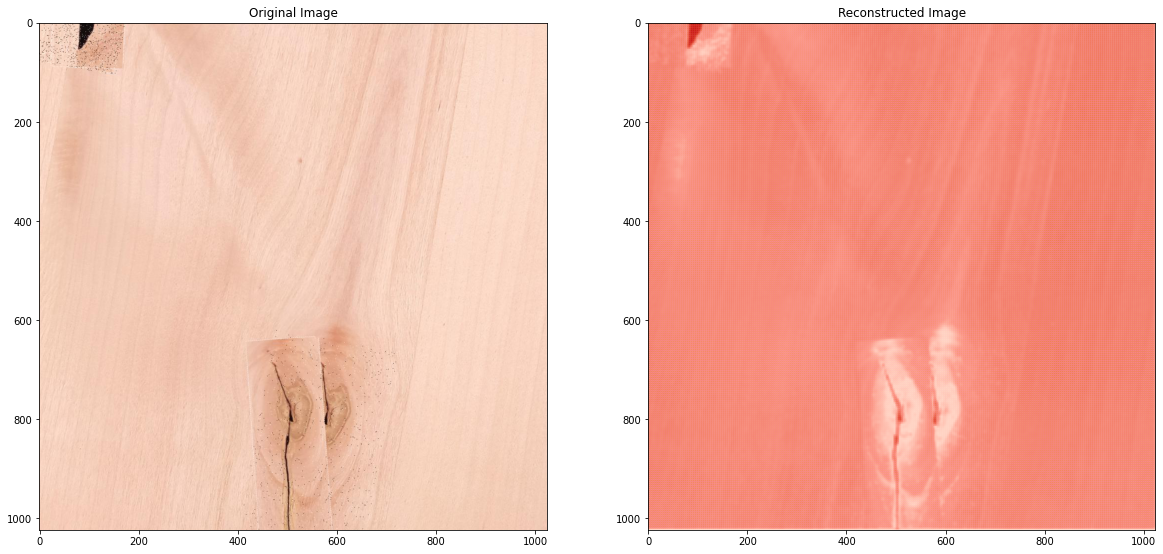

In [50]:
display_images(augmented_dataset, 16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


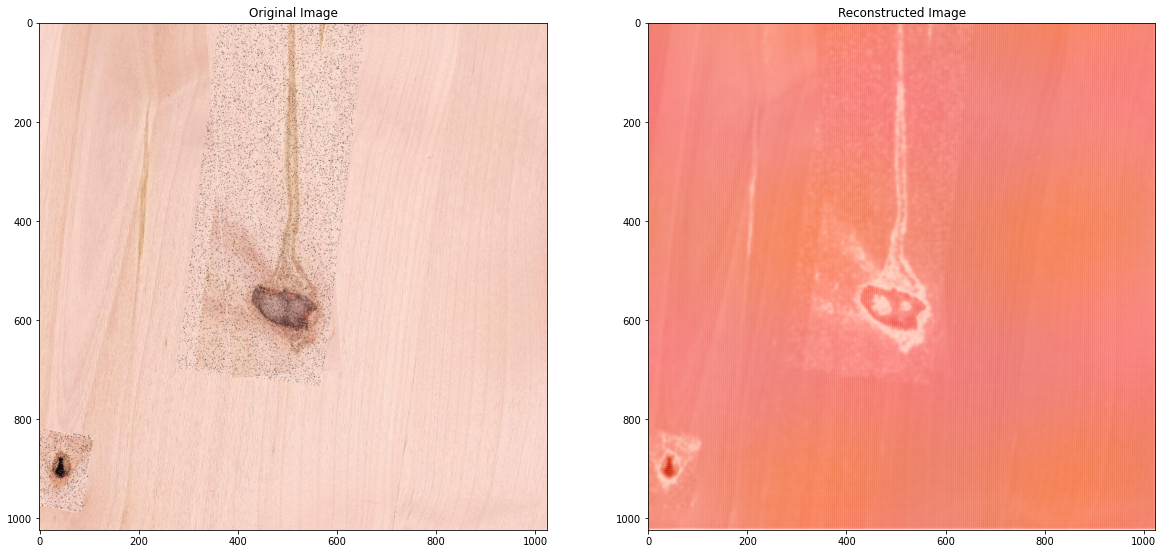

In [51]:
display_images(augmented_dataset, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


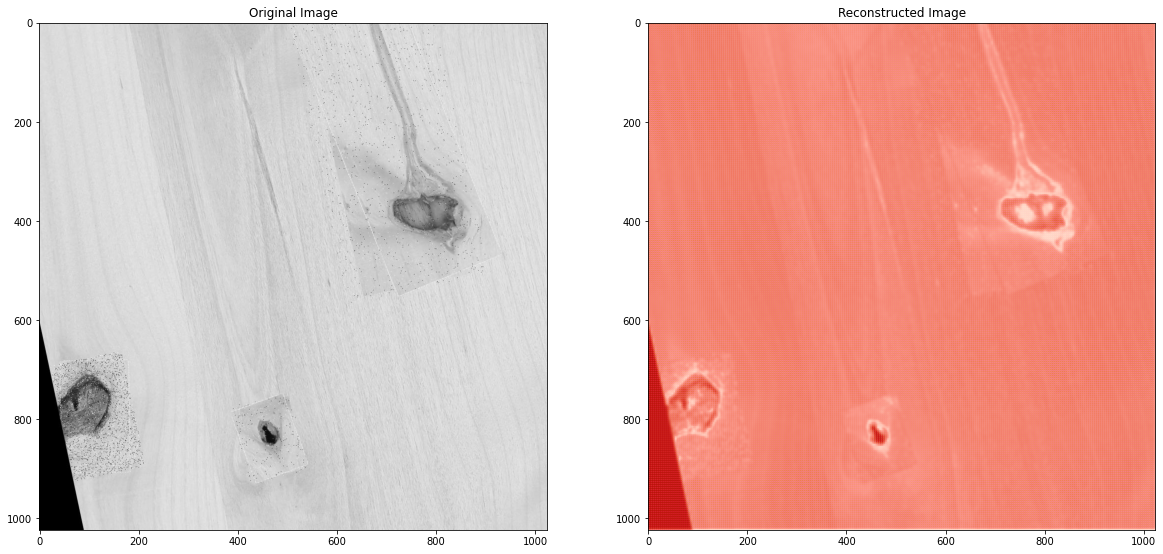

In [52]:
display_images(augmented_dataset, 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


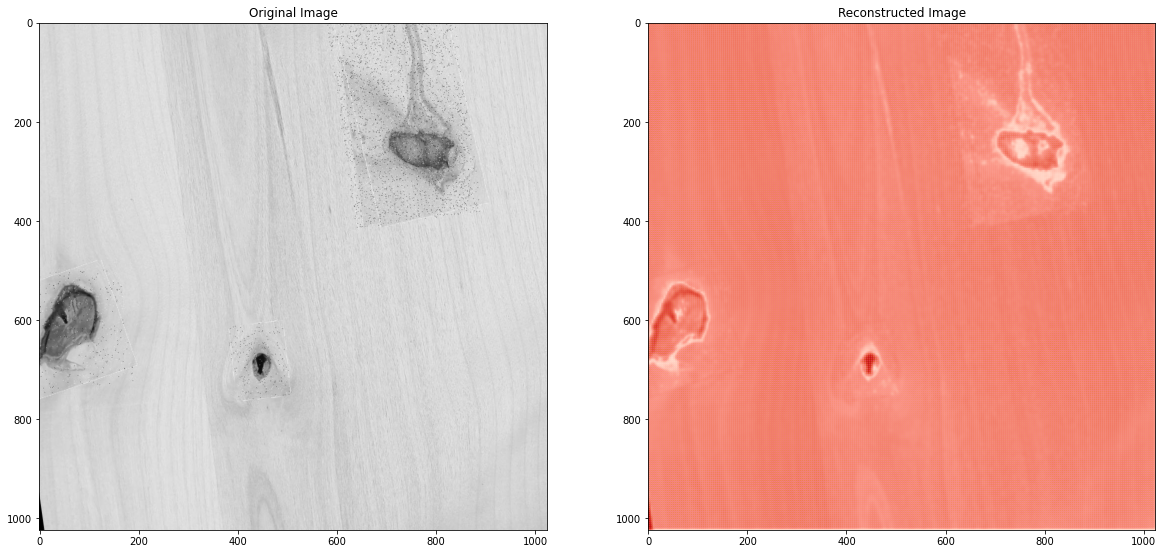

In [53]:
display_images(augmented_dataset, 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


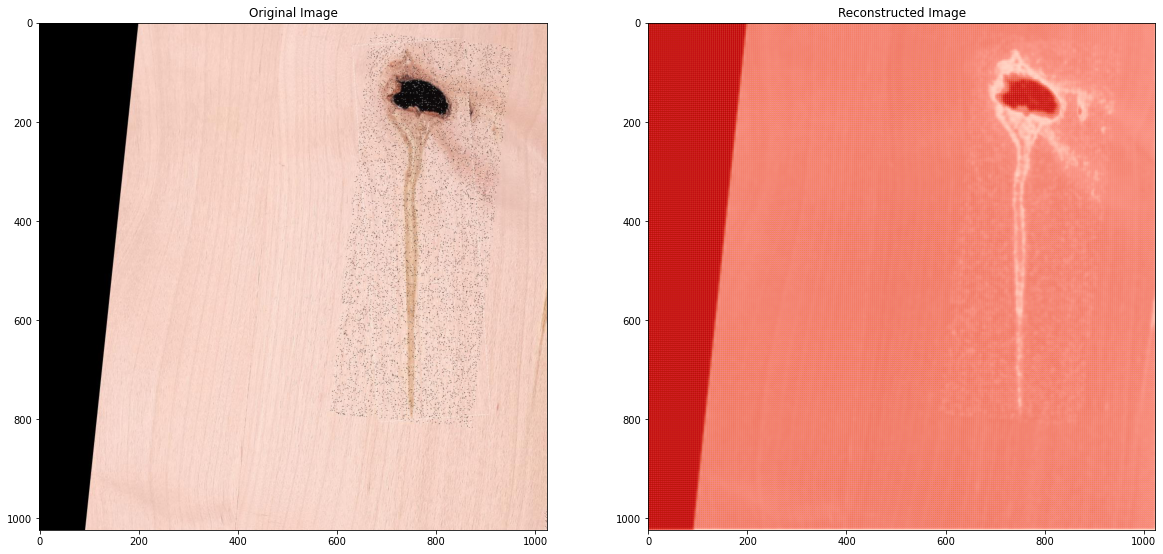

In [54]:
display_images(augmented_dataset, 12)

## Future Work

I would improve this model by generating more images 
through Data Augmentation with different features, so that every detail in the image will be captured and also by implementing a complex and deeper network model to train the images. \
### Performing the Transfer Learning
Performing the transfer learning is simple but before that using the model previously trained on large datasets gives better results. We can perform transfer learning by freezing the parameters(weights) of early convolutional layers of the network and only train the last few layers which make a prediction. The idea behind this is that convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image.\
Thus, we can use a network trained on unrelated categories in a massive dataset and apply it to on other problems because there are universal, low-level features shared between images.